# Tutorial 5 - FOSWEC
The goal of this tutorial is to show a design problem for a bottom-hinged oscillating-surge WEC.
The WEC in this tutorial is a single, fixed-bottom flap of the floating oscillating-surge WEC (FOSWEC).

* SAND report: https://doi.org/10.2172/1717884
* Journal paper: https://doi.org/10.1016/j.energy.2021.122485
* YouTube video: https://youtu.be/OUxbaEC2K6Y

This tutorial introduces...

In [1]:
import autograd.numpy as np
import capytaine as cpy
from capytaine.io.meshio import load_from_meshio
import matplotlib.pyplot as plt
from scipy.optimize import brute
import pygmsh
import gmsh
import xarray as xr
import ipympl

import wecopttool as wot

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

%matplotlib inline

Text(0, 0.5, 'Torque (Nm)')

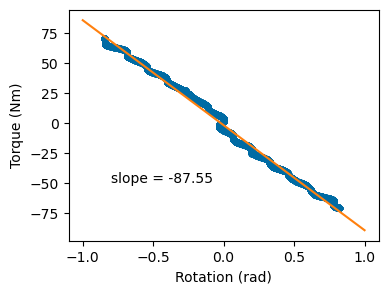

In [2]:
# load in data from ramps experiments
datafile = 'data/FOSWEC_ramps.nc'
ramps_data = xr.load_dataset(datafile)

# fit a linear curve
coefficients = np.polyfit(ramps_data['position'], ramps_data['torque'], 1)
pos_fitted = np.linspace(-1,1,100)
torque_fitted = np.polyval(coefficients, pos_fitted)

plt.figure(figsize=(4,3))
plt.plot(ramps_data['position'], ramps_data['torque'],'.')
plt.plot(pos_fitted,torque_fitted,'-')
plt.text(-0.8, -50, f'slope = {round(coefficients[0],2)}')
plt.xlabel('Rotation (rad)')
plt.ylabel('Torque (Nm)')

#plt.show()

## Single Flap Design Study
Because the hydrodynamics are so similar between both flaps of the FOSWEC (as evidenced by impedance plots above), we can simplify the design study to consider just one flap.
Results from the study should be applicable to both flaps. 


### Wave Conditions
Here, we define the wave conditions to select a proper frequency vector.
Because this study is only for regular waves, the fundamental frequency can be equal to the wave frequency and we only need about 12 frequencies total to capture all nonlinearities.

In [3]:
period = 8 # s
wavefreq = 1/period # Hz
amplitude = 0.2 # m
phase = 0 # degrees
wavedir = 0 # degrees

f1 = wavefreq
nfreq = 12

waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)
freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency

### Design Loop
The design loop here includes the tuned variables from above (draft and friction) as well as the center of gravity vertical location and rated generator power.
This enables a study which considers the impacts of changing the center of gravity of the flap (without altering the total mass) and using generators with different power ratings.

In [4]:
def one_flap_FOSWEC(draft, hs_coeff, z_cg_from_bottom, rotAngle):

    # parameters from experiments
    flap_height = 0.58 
    flap_draft = draft
    flap_freeboard = flap_height - flap_draft
    flap_width = 0.76
    flap_thickness_bottom = 0.05
    flap_thickness_top = 0.12
    hinge_location = -flap_draft - .046
    mass = 23.1
    pitch_inertia_about_cg = 1.19
    z_cg_from_bottom = z_cg_from_bottom
    z_cg = -flap_draft + z_cg_from_bottom

    mesh_size_factor = 0.2 # appropriate mesh size to avoid frequency spikes

    # mesh 1st flap
    with pygmsh.geo.Geometry() as geom:
        gmsh.option.setNumber('Mesh.MeshSizeFactor', mesh_size_factor)
        flap_poly = geom.add_polygon(
                [[-flap_thickness_bottom/2, -flap_width/2, -flap_draft],
                [flap_thickness_bottom/2, -flap_width/2, -flap_draft],
                [flap_thickness_top/2, -flap_width/2, flap_freeboard],
                [-flap_thickness_top/2, -flap_width/2, flap_freeboard]],mesh_size=mesh_size_factor)
        geom.rotate(flap_poly, [0,0,hinge_location], rotAngle, [0,1,0])
        geom.extrude(flap_poly,[0,flap_width,0])
        flap_mesh = geom.generate_mesh()

    # add degrees of freedom for rotation around bottom hinge
    flap_fb = cpy.FloatingBody(flap_mesh, name='flap_bow', center_of_mass=(0, 0, z_cg))
    axis = cpy.Axis(vector=(0, 1, 0), point=(0, 0, hinge_location))
    flap_fb.add_rotation_dof(name="Pitch") # used for BEM
    flap_fb.rotation_center = (0, 0, hinge_location) # rotation center hydrostatics if not defined manually
    flap_fb.keep_immersed_part()

    # use parallel axis theorem to move inertia to base
    pitch_inertia_about_base = pitch_inertia_about_cg + mass*(z_cg - hinge_location)**2
    rigid_inertia_matrix_xr = xr.DataArray(data=pitch_inertia_about_base,
                                dims=['influenced_dof', 'radiating_dof'],
                                coords={'influenced_dof': list(flap_fb.dofs),
                                        'radiating_dof': list(flap_fb.dofs)},
                                name="inertia_matrix")
    flap_fb.inertia_matrix = rigid_inertia_matrix_xr

    stiffness_matrix_xr = xr.DataArray(data=hs_coeff,
                                dims=['influenced_dof', 'radiating_dof'],
                                coords={'influenced_dof': list(flap_fb.dofs),
                                        'radiating_dof': list(flap_fb.dofs)},
                                name="hydrostatic_stiffness")
    flap_fb.hydrostatic_stiffness = stiffness_matrix_xr

    return flap_fb

In [5]:
flap_fb = one_flap_FOSWEC(0.53, 0, 0.17, 0) # set hydrostatic restoring coefficient to 0 so we can add it manually as nonlinear force
bem_data = wot.run_bem(flap_fb, freq) ## PTO impedance definition

[10:06:50] WARNING  center_of_mass already defined as [ 0.    0.   -0.36].

           WARNING  rotation_center already defined as (0, 0, -0.5760000000000001).

Output()

In [6]:
# compare nonlinear hydrostatic stiffness methods
flap_fb = one_flap_FOSWEC(0.53, 0, 0.17, 0.5)

#print(flap_fb.mesh.faces_normals[0])
#print(flap_fb.mesh.faces_areas[0])

# Does Capytaine consider area whne doing surface integral??

# simple example
face_normal = np.array((1, 0, 0))
face_area = 0.1
face_center = np.array((0, 0, -1))

av_simple = face_normal*np.transpose((face_area, face_area, face_area))
print(av_simple)
z = face_center[2]
pressureVect = 1000*9.81*np.transpose((-z, -z, -z))*-av_simple
print(pressureVect)

axis_pitch = np.array((0, 0, -0.53-.046))
axis_pitch_direction = np.array((0, 1, 0))
# Compute force about cog
f = np.zeros((6))
f[0:3] = pressureVect
center2cgVec = face_center-axis_pitch
print(center2cgVec)
print(np.cross(center2cgVec,pressureVect))

f[3:]= np.cross(center2cgVec,pressureVect) # this calculates the torque on the body
print(f[4])


print('CAPYTAINE')

print(flap_fb.mesh.faces_centers[1033,:])
motion = np.cross(axis_pitch - flap_fb.mesh.faces_centers[1033,:], axis_pitch_direction)

#print(flap_fb.dofs['pitch_bow_hinge'][0,:])
radiating_dof_normal_cpy = flap_fb.dof_normals(flap_fb.dofs['Pitch'])
print(radiating_dof_normal_cpy[1033])
radiating_dof_normal = np.sum(flap_fb.mesh.faces_normals[1033,:]*motion)
print(radiating_dof_normal)
z_influenced_dof_div = motion[2]
normal_z = -radiating_dof_normal * z_influenced_dof_div
print(normal_z)

# radiating_dof_normal is a list of values (1 for each face)

# Capytaine
motion = np.cross(axis_pitch - face_center, axis_pitch_direction)
print(motion)
radiating_dof_normal = np.sum(face_normal*motion)
print(radiating_dof_normal)
z_influenced_dof_div = motion[2]
normal_z = -radiating_dof_normal * z_influenced_dof_div
print(normal_z)
# surface integral multiplies input with faces_areas:
#surface_integral = sum(normal_z*face_area)
#print(surface_integral)
#stiffness = 1000*9.81*surface_integral
#print(stiffness)

[0.1 0.  0. ]
[-981.   -0.   -0.]
[ 0.     0.    -0.424]
[ -0.    415.944   0.   ]
415.94399999999996
CAPYTAINE
[ 0.01051926 -0.17857293 -0.50152784]
0.12358594357308651
-0.07186540922044146
-0.0007559710924712769
[-0.424  0.     0.   ]
-0.42399999999999993
0.0


In [7]:
# try extracting Capytaine's stiffness calculation
flap_fb = one_flap_FOSWEC(0.53, 0, 0.17, 0.5)

radiating_dof_normal = flap_fb.dof_normals(flap_fb.dofs['Pitch'])
z_influenced_dof_div = flap_fb.dofs['Pitch'][:,2] + flap_fb.mesh.faces_centers[:,2] * 0
norm_hs_stiff = flap_fb.surface_integral( -radiating_dof_normal * z_influenced_dof_div)

hs_stiff = 1000 * 9.81 * norm_hs_stiff

print(hs_stiff)

44.096686588216194


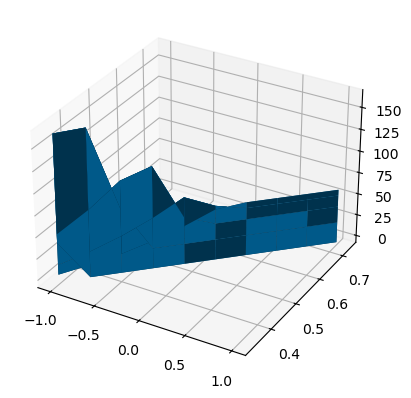

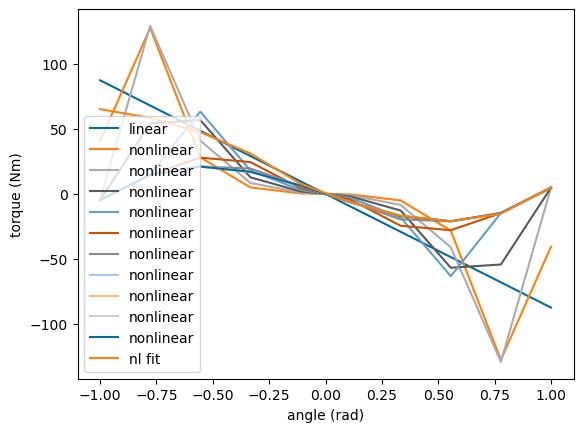

In [8]:
# create grid of hydroatatic stiffness values
import logging
logging.getLogger().setLevel(logging.ERROR)

angle_vec = np.linspace(-1,1,10)
draft_vec = np.linspace(0.53-amplitude,0.53+amplitude,10)
pitch_stiffness_vec = np.zeros((len(angle_vec),len(draft_vec)))

for angleInd, angle in enumerate(angle_vec):
    for draftInd, draft in enumerate(draft_vec):
        flap_fb = one_flap_FOSWEC(draft, 0, 0.17, angle)
        flap_fb = flap_fb.keep_immersed_part()
        hs = flap_fb.compute_hydrostatics()
        pitch_stiffness_vec[angleInd, draftInd] = hs['hydrostatic_stiffness']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(angle_vec,draft_vec,pitch_stiffness_vec)

hs_torque_lin = []
hs_torque_nl = []

for angle, pitch_stiffness in zip(angle_vec, pitch_stiffness_vec):
    hs_torque_lin.append(coefficients[0]*angle)
    hs_torque_nl.append(-pitch_stiffness*angle)

plt.figure()
plt.plot(angle_vec, np.squeeze(hs_torque_lin), label='linear')
plt.plot(angle_vec, np.squeeze(hs_torque_nl), label='nonlinear')
plt.xlabel('angle (rad)')
plt.ylabel('torque (Nm)')

# fit function to curve
coeffs_nl = np.polyfit(angle_vec, np.squeeze(hs_torque_nl),3)
nl_fit = np.polyval(coeffs_nl, angle_vec)
plt.plot(angle_vec, nl_fit, label='nl fit')
plt.legend()


Text(0.5, 0, 'hydrostatic stiffness')

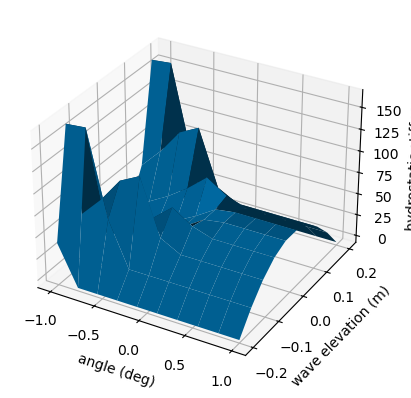

In [9]:
#%matplotlib ipympl

X, Y = np.meshgrid(angle_vec,draft_vec-0.53)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,pitch_stiffness_vec)
ax.set_xlabel('angle (deg)')
ax.set_ylabel('wave elevation (m)')
ax.set_zlabel('hydrostatic stiffness')


C:\Users\jtgrasb\AppData\Local\Temp\ipykernel_14468\3162228240.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  pitch_stiffness_check_ws.append(-f[4]/angle)


[[ 0.03833389 -0.38        0.0385527 ]
 [ 0.04425676 -0.38        0.05318333]
 [ 0.05109188 -0.38        0.0185385 ]
 ...
 [ 0.47162868  0.38        0.28234313]
 [ 0.45180462  0.38        0.28061804]
 [ 0.06552021  0.38        0.04174236]]
[[ 0.          1.40118837 -0.        ]
 [-0.          1.59600977 -0.        ]
 [-0.          1.43732272 -0.        ]
 ...
 [-0.         -1.37336568 -0.        ]
 [ 0.         -1.21642074 -0.        ]
 [-0.         -1.75725371  0.        ]]
[-4.81027959  6.42538563 16.80698119 26.23039096 34.60039274 44.08235373
 67.81064103 75.57487948 56.38803134 46.10194738 42.86040295 46.10199351
 56.3883213  75.57499066 67.81095372 44.08249124 34.60039279 26.23033255
 16.80692738  6.42533718 -4.81009275]
[116.23456953 120.2251074  123.86254942 127.12477971 129.99193337
 132.42861265 131.52019473 124.85200404 117.96962083 114.12409789
          inf 114.10761198 117.98817818 124.85565439 131.52061712
 132.42880442 129.9919316  127.12459351 123.86270942 120.2252589


C:\Users\jtgrasb\AppData\Local\Temp\ipykernel_14468\3162228240.py:51: RuntimeWarning: invalid value encountered in scalar multiply
  hs_torque_nl_ws.append(-pitch_stiffness_ws*angle)


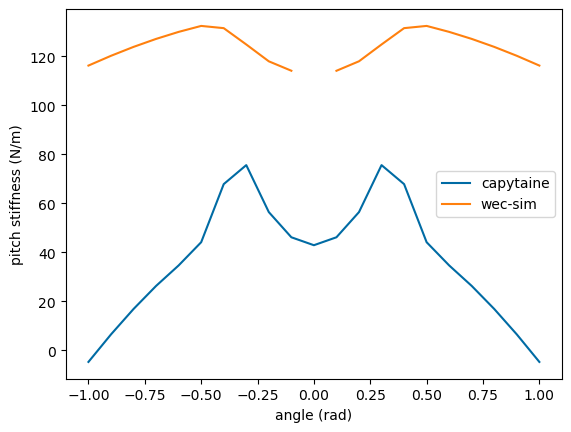

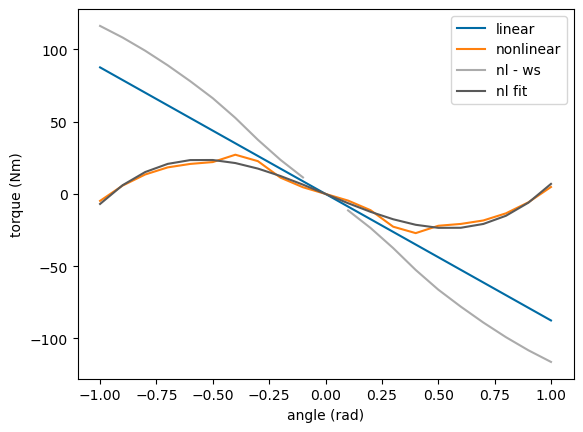

In [10]:
import logging
logging.getLogger().setLevel(logging.ERROR)

angle_vec = np.linspace(-1,1,21)
pitch_stiffness_vec = []
pitch_stiffness_check = []
pitch_stiffness_check_ws = []

for angle in angle_vec:
    flap_fb = one_flap_FOSWEC(0.53, 0, 0.17, angle)
    flap_fb = flap_fb.keep_immersed_part()
    
    hs = flap_fb.compute_hydrostatics()
    pitch_stiffness_vec.append(hs['hydrostatic_stiffness'])

    av = flap_fb.mesh.faces_normals*np.transpose((flap_fb.mesh.faces_areas, flap_fb.mesh.faces_areas, flap_fb.mesh.faces_areas)) # av is normals*areas
    z = flap_fb.mesh.faces_centers[:,2]
    pressureVect = 1000*9.81*np.transpose((-z, -z, -z))*-av
    axis_pitch = (0, 0, -0.53-.046)
    #axis_pitch = (0, 0, -0.29)
    # Compute force about cog
    f = np.zeros((6))
    f[0:3] = sum(pressureVect)
    tmp1 = np.ones((len(flap_fb.mesh.faces_centers[:,0]),1))
    tmp2 = tmp1*np.transpose(axis_pitch) # does it make sense that this would be 3x1?
    center2cgVec = flap_fb.mesh.faces_centers-tmp2
    f[3:]= sum(np.cross(center2cgVec,pressureVect))
    pitch_force_check = f[4]
    pitch_stiffness_check_ws.append(-f[4]/angle)

print(center2cgVec)
print(pressureVect)

print(np.squeeze(pitch_stiffness_vec))
print(np.squeeze(pitch_stiffness_check_ws))

plt.figure()
plt.plot(angle_vec, np.squeeze(pitch_stiffness_vec),label='capytaine')
plt.plot(angle_vec, np.squeeze(pitch_stiffness_check_ws),label='wec-sim')
plt.xlabel('angle (rad)')
plt.ylabel('pitch stiffness (N/m)')
plt.legend()

hs_torque_lin = []
hs_torque_nl = []
hs_torque_nl_ws = []

for angle, pitch_stiffness, pitch_stiffness_ws in zip(angle_vec, pitch_stiffness_vec, pitch_stiffness_check_ws):
    hs_torque_lin.append(coefficients[0]*angle)
    hs_torque_nl.append(-pitch_stiffness*angle)
    hs_torque_nl_ws.append(-pitch_stiffness_ws*angle)

plt.figure()
plt.plot(angle_vec, np.squeeze(hs_torque_lin), label='linear')
plt.plot(angle_vec, np.squeeze(hs_torque_nl), label='nonlinear')
plt.plot(angle_vec, np.squeeze(hs_torque_nl_ws), label='nl - ws')
plt.xlabel('angle (rad)')
plt.ylabel('torque (Nm)')


# fit function to curve
coeffs_nl = np.polyfit(angle_vec, np.squeeze(hs_torque_nl),3)
nl_fit = np.polyval(coeffs_nl, angle_vec)
plt.plot(angle_vec, nl_fit, label='nl fit')
plt.legend()

In [15]:
#print(av[100:200])
print(sum(pressureVect))

[ 5.82756066e-13 -1.35891298e-13  3.67561080e+02]


AttributeError: 'float' object has no attribute 'type'

In [24]:
# compute nonlinear Froude-Krylov forces
f = np.zeros(len(center[:,3]),1) # based on face centers
fk = np.zeros(len(center[:,3]),1) # based on face centers
z= np.zeros(len(center[:,1]),1) # based on face centers

cx = center[:,1];
cy = center[:,2];
X = cx
if deepWater == 0 && wDepth <= 0.5*pi/k(i)
    z = (center[:,3]-elv).*wDepth./(wDepth+elv);
    f_tmp = rho.*g.*sqrt(amplitude*dw(i)).*cos(k(i).*X-w(i)*t-phaseRand(i,kk));
    fk(:,1) = fk(:,1) + spread(kk) .* f_tmp.*(cosh(k(i).*(z+wDepth))./cosh(k(i).*wDepth));
else
    z=(center(:,3)-elv);
    f_tmp = rho.*g.*sqrt(amplitude*dw(i)).*cos(k(i).*X-w(i)*t-phaseRand(i));
    fk(:,1) = fk(:,1) + spread(kk) .*f_tmp.*exp(k(i).*z);
end
    f=fk+f;
end
% elseif typeNum < 40
%     error('fullDirectionalSpectrum import not supported with nonlinear hydro')
end
f(z>0)=0;

In [10]:
# add hydrostatic restoring force manually
k_hs = -coefficients[0]

k_hs_nl = pitch_stiffness_vec

def f_hs_lin(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos_fd = wec.vec_to_dofmat(x_wec)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    pos_td = np.dot(time_matrix, pos_fd)
    hydrostatic_restoring_force = -k_hs*pos_td
    return hydrostatic_restoring_force

def f_hs_nl(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos_fd = wec.vec_to_dofmat(x_wec)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    pos_td = np.dot(time_matrix, pos_fd)
    nl_hs_at_pos = float(coeffs_nl[0])*pos_td**3 + float(coeffs_nl[1])*pos_td**2 + float(coeffs_nl[2])*pos_td + float(coeffs_nl[3])
    return nl_hs_at_pos

In [11]:
omega = bem_data.omega.values
gear_ratio = 3.75
torque_constant = 6.7
winding_resistance = 0.5
winding_inductance = 0
drivetrain_inertia = 0
drivetrain_friction = 0
drivetrain_stiffness = 0

drivetrain_impedance = (1j*omega*drivetrain_inertia + 
                        drivetrain_friction + 
                        1/(1j*omega)*drivetrain_stiffness) 

winding_impedance = winding_resistance + 1j*omega*winding_inductance


pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape) 
pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
pto_impedance_22 = winding_impedance
pto_impedance = np.array([[pto_impedance_11, pto_impedance_12],
                        [pto_impedance_21, pto_impedance_22]])

## Update PTO
name = ['PTO_Pitch']
kinematics = np.eye(1)
pto_ndof = 1
controller = None # unstructured controller
loss = None
pto = wot.pto.PTO(pto_ndof, kinematics, controller, pto_impedance, loss, name)

# PTO dynamics forcing function
f_add = {'PTO': pto.force_on_wec,'hydrostatic_restoring': f_hs_nl}

# Constraint
pos_max = 60*np.pi/180
rms_max = 20
nsubsteps = 4

def const_pos_pto(wec, x_wec, x_opt, waves):
    pos = pto.position(wec, x_wec, x_opt, waves, nsubsteps) # computed pto position is the same as wec position
    return pos_max - np.abs(pos.flatten())

def const_rms_power_pto(wec, x_wec, x_opt, waves):
    power = pto.power(wec, x_wec, x_opt, waves, nsubsteps)
    return rms_max - np.sqrt(np.mean(power**2))

constraints = [{'type': 'ineq', 'fun': const_pos_pto}, {'type': 'ineq', 'fun': const_rms_power_pto}] 

wec = wot.WEC.from_bem(bem_data,
                        constraints=constraints,
                        friction=12*np.eye(1), # tuned variable
                        f_add=f_add,)

In [12]:
print(waves)

<xarray.DataArray 'wave_elev' (omega: 12, wave_direction: 1, realization: 1)> Size: 192B
array([[[1.+0.j]],

       [[0.+0.j]],

       [[0.+0.j]],

       [[0.+0.j]],

       [[0.+0.j]],

       [[0.+0.j]],

       [[0.+0.j]],

       [[0.+0.j]],

       [[0.+0.j]],

       [[0.+0.j]],

       [[0.+0.j]],

       [[0.+0.j]]])
Coordinates:
  * omega           (omega) float64 96B 0.7854 1.571 2.356 ... 7.854 8.639 9.425
    freq            (omega) float64 96B 0.125 0.25 0.375 0.5 ... 1.25 1.375 1.5
  * wave_direction  (wave_direction) float64 8B 0.0
  * realization     (realization) int32 4B 0
Attributes:
    units:                m
    long_name:            Wave elevation
    Wave type:            Regular
    Frequency (Hz):       0.125
    Amplitude (m):        1
    Phase (degrees):      0
    Direction (degrees):  0


In [161]:
import logging
logging.getLogger().setLevel(logging.INFO)

# Update objective function
nstate_opt = 2*nfreq

# Solve
scale_x_wec = 1e1
scale_x_opt = 1e-1
scale_obj = 1e-1

options = {'maxiter': 400}

nsubsteps = 4

obj_fun = pto.average_power
    
results = wec.solve(
    waves, 
    obj_fun, 
    nstate_opt, 
    optim_options=options, 
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
)


c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:759: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 0.
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.22e+00, 8.48e+02, 1.56e+04]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.57e+01, 4.56e+02, 1.48e+04]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.31e+00, 1.55e+02, 6.05e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.56e+00, 9.38e+01, 5.31e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.82e+01, 6.23e+01, 2.74e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.91e+00, 4.57e+01, 1.94e+02]
INFO:w

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.3407420694802585
            Iterations: 134
            Function evaluations: 142
            Gradient evaluations: 134


### Results


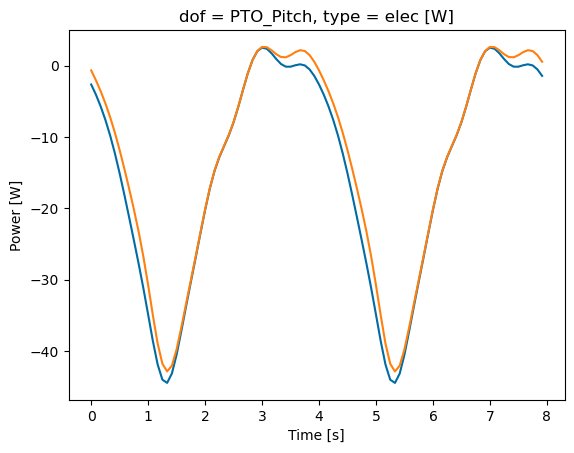

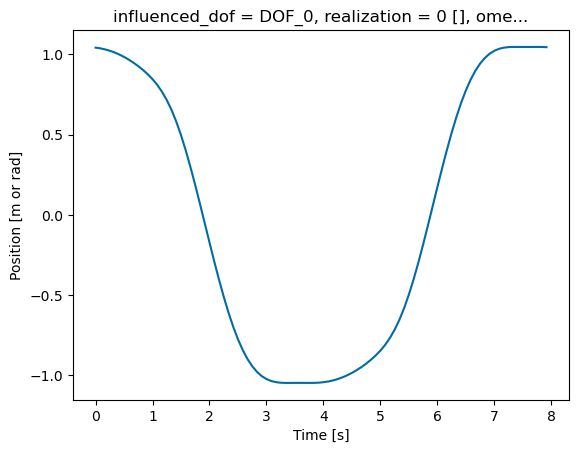

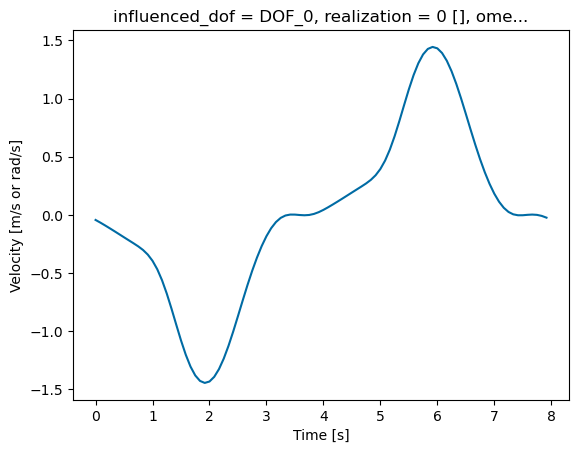

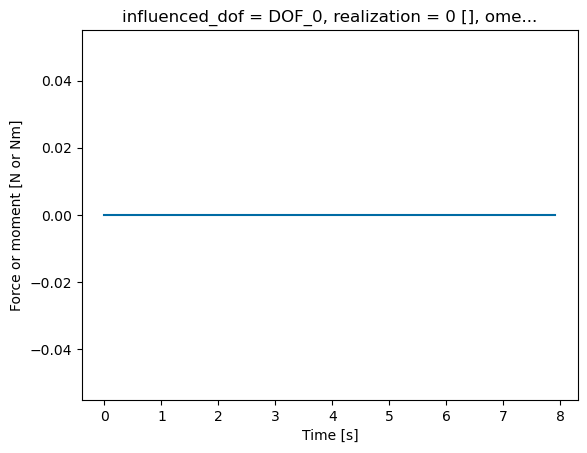

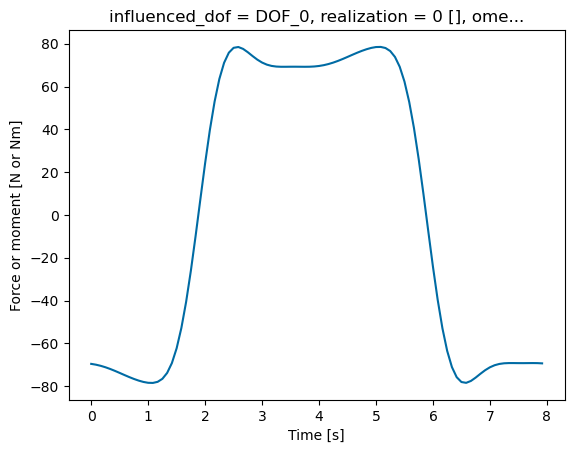

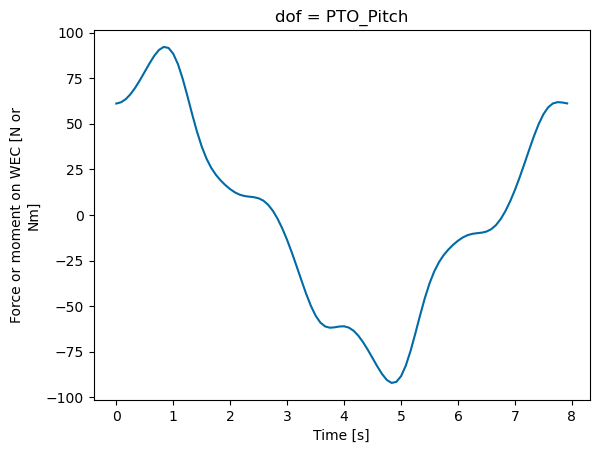

In [163]:
pto_fdom, pto_tdom = pto.post_process(wec, results, waves, nsubsteps=nsubsteps)
wec_fdom, wec_tdom = wec.post_process(wec, results, waves, nsubsteps=nsubsteps)

plt.figure()
pto_tdom[0]['power'].loc['mech',:,:].plot()
pto_tdom[0]['power'].loc['elec',:,:].plot()

plt.figure()
wec_tdom[0]['pos'].plot()

plt.figure()
wec_tdom[0]['vel'].plot()

plt.figure()
wec_tdom[0]['force'].sel(type='hydrostatics').plot()

plt.figure()
wec_tdom[0]['force'].sel(type='hydrostatic_restoring').plot()

plt.figure()
pto_tdom[0]['force'].plot()